In [2]:
import sys
import logging
import pickle
import yaml
import matplotlib.cm as cm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import time
from configs import engram_dir

In [3]:
sys.path.append('..')
from scripts.model_parameters.dicarlo_swap import *

# Parameters

In [4]:
internal_dim = 16
network_yaml = 'dm'
generic_exp_name_pre = 'postbug_gridworld8x8_shuffobs'
generic_exp_name_post = f'dicarlo_swap_{generic_exp_name_pre}'
pre_episode = 600
post_episode = 1
param_loading_func = postbug_contig

# Loading analysis dataframes and swap parameters

In [5]:
def get_repr_df(generic_exp_name, episode):
    exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
    nnets_dir = f'{engram_dir}nnets/{exp_name}/'
    analysis_dir = f'{engram_dir}analysis/{exp_name}/'
    with open(f'{analysis_dir}representation_df_ep{episode}.p', 'rb') as f:
        repr_df = pickle.load(f)
    return repr_df

In [6]:
def get_fr_map(generic_exp_name, episode, model, i, unit):
    repr_df = get_repr_df(generic_exp_name, episode)
    _df = repr_df[repr_df['model'] == f'{generic_exp_name}_{model}']
    _df = _df[_df['iteration'] == i]
    
    width = np.max(_df['x']) + 2
    height = np.max(_df['y']) + 2
    _sample = np.array(_df.head(1)['latents'].item())
    n_units = _sample.size
    heatmap = np.zeros((n_units, width, height))
    for _, row in _df.iterrows():
        x = row['x']
        y = row['y']
        latents = np.array(row['latents'])
        heatmap[:,x,y] = latents
    m = heatmap[unit]
    m[m<0] = 0
    return m

In [7]:
swap_params = param_loading_func()

# Make encoder receptive fields

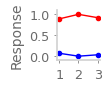

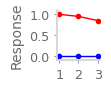

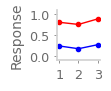

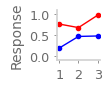

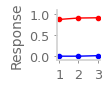

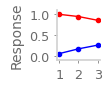

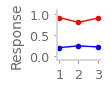

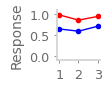

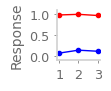

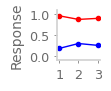

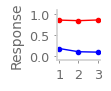

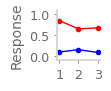

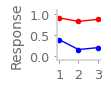

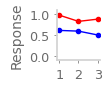

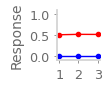

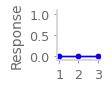

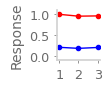

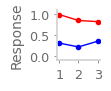

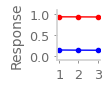

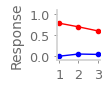

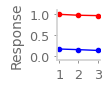

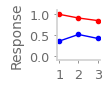

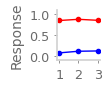

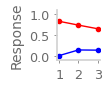

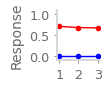

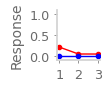

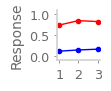

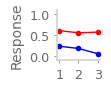

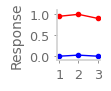

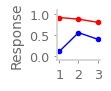

In [37]:
os.makedirs('4c', exist_ok=True)
for key in swap_params.keys():
    _swap_params = swap_params[key]
    key_split = key[::-1].index('_')
    if 'noq' not in key: continue
    model = key[:-key_split-1]
    i = int(key[-key_split:])
    unit = int(_swap_params['chosen_unit'])

    fr_pre = get_fr_map(
        generic_exp_name_pre, pre_episode, model, i, unit)
    fr_post = get_fr_map(
        generic_exp_name_post, post_episode, model, i, unit)
    fr_pre /= fr_pre.max()
    fr_post /= fr_post.max()
    figsize = (1., 0.8)
    markersize = 3

    plt.figure(figsize=figsize, constrained_layout=True)
    a = fr_pre[_swap_params['a']]
    b = fr_pre[_swap_params['b']]
    c = fr_pre[_swap_params['c']]
    d = fr_pre[_swap_params['d']]
    e = fr_pre[_swap_params['e']]
    f = fr_pre[_swap_params['f']]
    plt.plot([0,1,2], [a,b,c], color='red', marker='o', markersize=markersize)
    plt.plot([0,1,2], [d,e,f], color='blue', marker='o', markersize=markersize)
    plt.yticks([0, 0.5, 1.])
    plt.xticks([0,1,2], [1,2,3])
    plt.ylabel('Response')
    plt.title(None)
    plt.ylim(-0.1, 1.1)
    plt.savefig(f'4c/{i}_before.png', dpi=300, transparent=True)
    plt.show()
    
    a = fr_post[_swap_params['a']]
    b = fr_post[_swap_params['b']]
    c = fr_post[_swap_params['c']]
    d = fr_post[_swap_params['d']]
    e = fr_post[_swap_params['e']]
    f = fr_post[_swap_params['f']]
        
    plt.figure(figsize=figsize, constrained_layout=True)
    plt.plot([0,1,2], [a,b,c], color='red', marker='o', markersize=markersize)
    plt.plot([0,1,2], [d,e,f], color='blue', marker='o', markersize=markersize)
    plt.title(f'{model}, iteration {i}')
    plt.yticks([0, 0.5, 1.])
    plt.xticks([0,1,2], [1,2,3])
    plt.ylabel('Response')
    plt.title(None)
    plt.ylim(-0.1, 1.1)
    plt.savefig(f'4c/{i}_after.png', dpi=300, transparent=True)
    plt.show()

# Measure summary statistics

In [22]:
data = {
    'model': [],
    'ad_diff': [],
    'be_diff': [],
    'cf_diff': [],
    }

for key in swap_params.keys():
    _swap_params = swap_params[key]
    key_split = key[::-1].index('_')
    model = key[:-key_split-1]
    i = int(key[-key_split:])
    unit = int(_swap_params['chosen_unit'])

    fr_pre = get_fr_map(
        generic_exp_name_pre, pre_episode, model, i, unit)
    fr_post = get_fr_map(
        generic_exp_name_post, post_episode, model, i, unit)
    fr_pre /= fr_pre.max()
    if fr_post.max() > 0:
        fr_post /= fr_post.max()

    a = fr_pre[_swap_params['a']]
    b = fr_pre[_swap_params['b']]
    c = fr_pre[_swap_params['c']]
    d = fr_pre[_swap_params['d']]
    e = fr_pre[_swap_params['e']]
    f = fr_pre[_swap_params['f']]
    post_a = fr_post[_swap_params['a']]
    post_b = fr_post[_swap_params['b']]
    post_c = fr_post[_swap_params['c']]
    post_d = fr_post[_swap_params['d']]
    post_e = fr_post[_swap_params['e']]
    post_f = fr_post[_swap_params['f']]
    data['model'].append(model)
    data['ad_diff'].append((post_a-post_d) - (a-d))
    data['be_diff'].append((post_b-post_e) - (b-e))
    data['cf_diff'].append((post_c-post_f) - (c-f))

In [23]:
formatted_data = {'model':[], 'diff': [], 'index': []}
for i in range(len(data['model'])):
    for index, seq in enumerate(['ad', 'be', 'cf']):
        formatted_data['model'].append(data['model'][i])
        formatted_data['diff'].append(data[f'{seq}_diff'][i])
        formatted_data['index'].append(index)

In [24]:
df = pd.DataFrame(formatted_data)

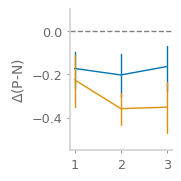

In [38]:
fig, ax = plt.subplots(figsize=(1.7, 1.7), constrained_layout=True)
sns.lineplot(
    x='index', y='diff',
    hue='model', hue_order=['entro-1', 'g0_-2_entro-1'],
    palette=['C0', 'C1'],
    err_style='bars',
    data=df, ax=ax, legend=None)
ax.set_ylim(-0.55, 0.1)
ax.axhline(0, color='gray', linestyle='--')
plt.xlabel(None)
plt.xticks([0,1,2], [1,2,3])
plt.ylabel('$\Delta$(P-N)')
plt.savefig('4d.png', dpi=300, transparent=True)
plt.show()